In [ ]:
# chronic kidney disease classification

# dataset from https://archive.ics.uci.edu/ml/datasets/Chronic_Kidney_Disease

'''
Analysis summary:
  1. Data import
  2. Data exploration and cleaning
  3. Modeling with keras using one hidden layer and a sigmoid activation at output layer
  4. K-fold cross validation since dataset is quite small (m = 399 samples)
  5. Plot model accuracy and loss for training and validation data
  6. Evaluate model on test data using optimum number of epochs
'''

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from IPython.display import clear_output

In [6]:
# read data and add column labels

# limit data to the expected 25 columns to deal with extra commas at the end of some lines; skip header info
df = pd.read_csv('chronic_kidney_disease.arff', skiprows=29, usecols=range(0,25))

# label columns
cols = ['age','bp','sg','al','su','rbc','pc','pcc','ba',
        'bgr','bu','sc','sod','pot','hemo','pvc','wc','rc',
        'htn','dm','cad','appet','pe','ane','class']
df.columns = cols

# fix data types
cols = ['age','bp','bgr','bu','sc','sod','pot','hemo','pvc','wc','rc','sg']
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pvc,wc,rc,htn,dm,cad,appet,pe,ane,class
0,7.0,50.0,1.020,4,0,?,normal,notpresent,notpresent,NaN,...,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
1,62.0,80.0,1.010,2,3,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
2,48.0,70.0,1.005,4,0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
3,51.0,80.0,1.010,2,0,normal,normal,notpresent,notpresent,106.0,...,35.0,7300.0,4.6,no,no,no,good,no,no,ckd
4,60.0,90.0,1.015,3,0,?,?,notpresent,notpresent,74.0,...,39.0,7800.0,4.4,yes,yes,no,good,yes,no,ckd


In [14]:
# some columns are missing data
df.count()

age      390
bp       387
sg       352
al       399
su       399
rbc      399
pc       399
pcc      399
ba       399
bgr      355
bu       380
sc       382
sod      313
pot      312
hemo     347
pvc      328
wc       293
rc       268
htn      399
dm       398
cad      399
appet    399
pe       399
ane      399
class    399
dtype: int64

<Figure size 1440x720 with 0 Axes>

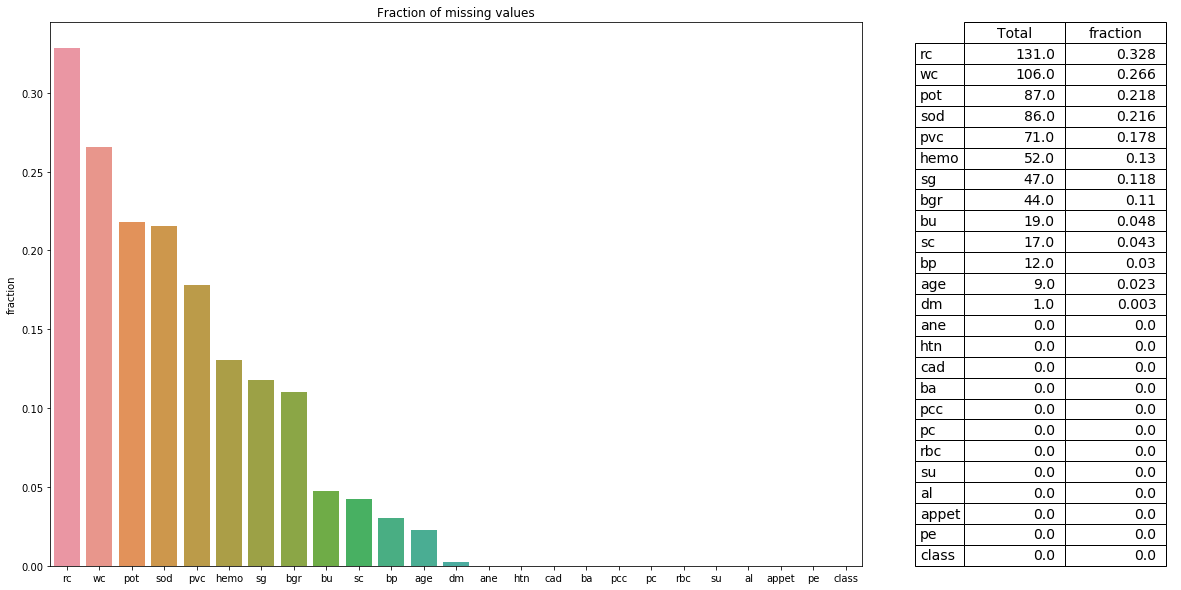

In [31]:
# count missing data in each column
total = df.isnull().sum().sort_values(ascending=False)
fraction = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, fraction], axis=1, keys=['Total', 'fraction'])

# visualize counts
fig = plt.figure(figsize=(20,10))

f, (a0, a1) = plt.subplots(1,2, gridspec_kw = {'width_ratios':[4, 1]}, figsize=(20,10))
sns.barplot(x=missing_data.index, y=missing_data['fraction'], ax=a0).set_title('Fraction of missing values')
font_size=14
bbox=[0, 0, 1, 1]
a1.axis('off')
mpl_table = a1.table(cellText = np.round(missing_data.values, decimals=3),
                     rowLabels = missing_data.index,
                     bbox=bbox, colLabels=missing_data.columns)
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(font_size)

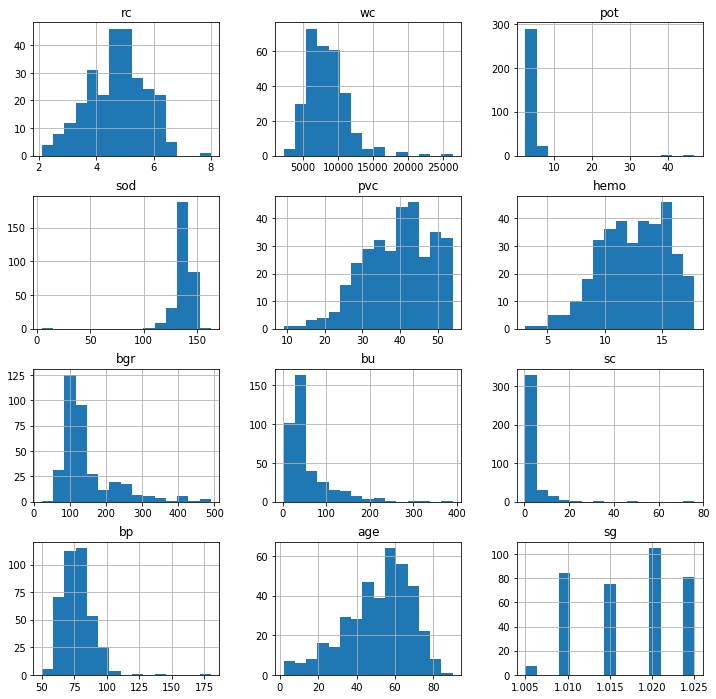

In [32]:
# plot histograms for numeric features with NaN to see distributions
df_missing = df[['rc','wc','pot','sod','pvc','hemo','bgr','bu','sc','bp','age','sg']]

fig, axes = plt.subplots(4, 3, figsize=(12, 12))

i = 0
for triaxis in axes:
    for axis in triaxis:
        df_missing.dropna(subset=[df_missing.columns[i]]).hist(column = df_missing.columns[i], bins = 15, ax=axis)
        i = i+1

In [33]:
# some features have outliers and are non-gaussian distributions, so median fill may be a good choice

# apply median fill for NaN values in full dataframe for the numeric columns
df_fillna = df.fillna(df.median())

# now fill categorical values with most frequent entries
for val in ['', 'NULL', '?']:
    df_fillna.replace(val, df_fillna.mode().iloc[0], inplace=True)

# now check counts to make sure fill worked
df_fillna.count()

# looks like 'dm' is missing a value; let's look at unique entries in each column
def unique_entries(df_):
    for col in df_:
        print(col + ': ', end='')
        print(df_[col].unique())
unique_entries(df_fillna)
    
# 'dm' and 'cad' have some problems, but it's clear what the values should be
df_fillna = df_fillna.replace('\tno','no').replace('\tyes','yes').replace(' yes','yes')
# there's a problem with some of the labels ('class' column) too
df_fillna = df_fillna.replace('ckd\t','ckd')
# 'class' also has one entry of 'no', which might mean 'notckd', but let's drop it since it's not clear
df_fillna['class'].value_counts()
df_fillna = df_fillna[df_fillna['class'] != 'no']

# now one more look at the counts and unique values
clear_output()
unique_entries(df_fillna)
df_fillna.count()

# looks good now!
clear_output()
df2 = df_fillna

In [34]:
# the feature scales vary by several orders of magnitude, so we should normalize them

# get list of numeric column names and normalize those columns
numeric_cols = [key for key in dict(df2.dtypes) if dict(df2.dtypes)[key] in ['float64']]
df2_numeric_normalized = (df2[numeric_cols] - df2[numeric_cols].mean())/df2[numeric_cols].std()

# get object columnsa and concatenatre with normalized columns
df_object = df2.select_dtypes(include='object')
df2_normalized = pd.concat([df_object,df2_numeric_normalized], axis=1)

df2_normalized.head(10)

,al,su,rbc,pc,pcc,ba,htn,dm,cad,appet,...,sg,bgr,bu,sc,sod,pot,hemo,pvc,wc,rc
0,4,0,normal,normal,notpresent,notpresent,no,no,no,good,...,0.422201,-0.321133,-0.783063,-0.391255,0.041813,-0.063793,-0.450986,-0.128832,-0.905630,0.075386
1,2,3,normal,normal,notpresent,notpresent,no,yes,no,poor,...,-1.414257,3.683317,-0.076087,-0.213989,0.041813,-0.063793,-1.076266,-0.985454,-0.313644,0.075386
2,4,0,normal,abnormal,present,notpresent,yes,no,no,poor,...,-2.332485,-0.374172,-0.015490,0.140543,-2.885359,-0.735664,-0.487767,-0.863079,-0.629370,-0.991938
3,2,0,normal,normal,notpresent,notpresent,no,no,no,good,...,-1.414257,-0.520030,-0.621469,-0.284895,0.041813,-0.063793,-0.340642,-0.495955,-0.392575,-0.161797
4,3,0,normal,normal,notpresent,notpresent,yes,yes,no,good,...,-0.496028,-0.944342,-0.641668,-0.338075,0.475468,-0.488133,-0.119955,-0.006457,-0.195247,-0.398980
5,0,0,normal,normal,notpresent,notpresent,no,no,no,good,...,-1.414257,-0.599588,-0.055888,3.721317,-3.644255,-0.205240,-0.046392,-0.373581,-0.116315,0.075386
6,2,4,normal,abnormal,notpresent,notpresent,no,yes,no,good,...,-0.496028,3.510940,-0.520472,-0.338075,0.041813,-0.063793,-0.046392,0.605416,-0.550439,0.312569
7,3,0,normal,abnormal,present,notpresent,yes,yes,no,good,...,-0.496028,-0.095717,0.065308,-0.196262,0.041813,-0.063793,-0.634892,-0.740705,0.515137,-0.873347
8,2,0,abnormal,abnormal,present,notpresent,yes,yes,no,poor,...,0.422201,-0.997381,1.014675,0.743248,-2.560117,-0.311325,-1.113048,-1.230203,1.501782,-1.229121
9,2,4,normal,abnormal,present,notpresent,yes,yes,no,good,...,-1.414257,4.571722,-0.035689,0.175997,0.041813,-0.063793,-1.149829,-1.352578,-0.116315,0.075386


In [35]:
# now, one hot encode the categorical features

# drop_first=True, e.g. we only need one column for sex: i.e., female = True or False
df_feat = pd.get_dummies(df2_normalized.drop(['class'], axis=1), drop_first=True)

# encode the labels too
df_label = pd.get_dummies(df2_normalized[['class']]).drop(['class_notckd'], axis=1)

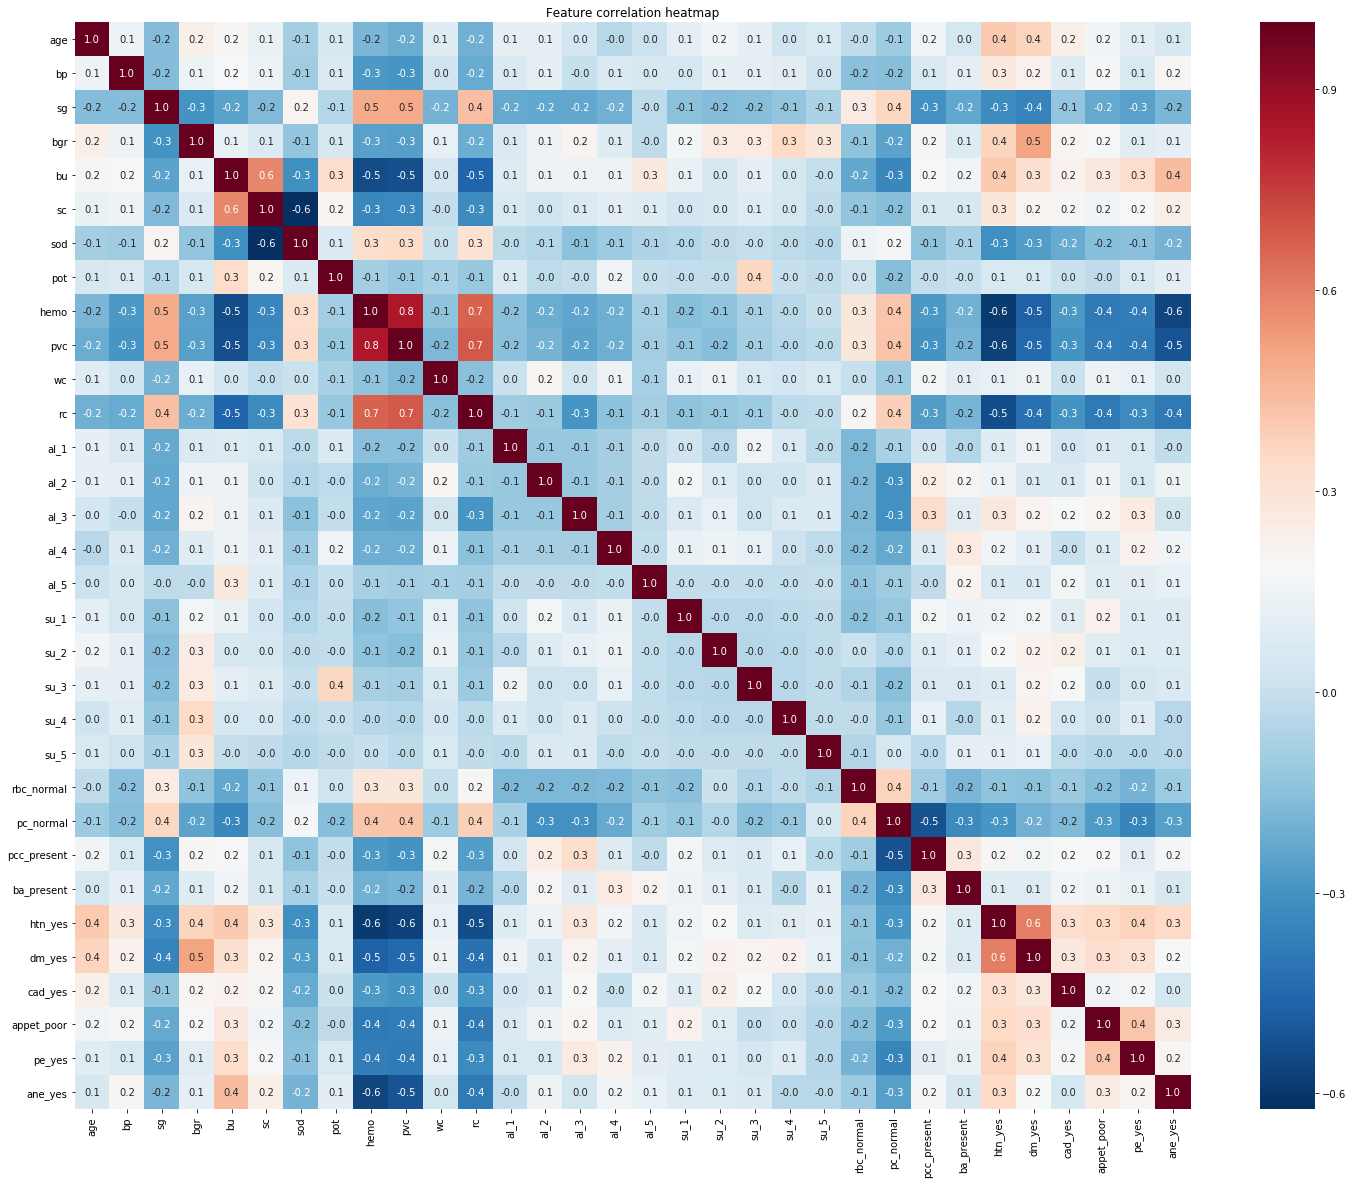

In [36]:
# next, take a look at correlated features
corr = df_feat.corr()
size = 20
fig = plt.figure(figsize=(1.25*size,size))
ax = plt.axes()
ax.set_title('Feature correlation heatmap')
sns.heatmap(corr, annot=True, fmt='.1f', cmap="RdBu_r",
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [41]:
# there are a few moderately correlated values, but try using all features for now

# split data set into training and test sets
from sklearn.model_selection import train_test_split

X = df_feat.values
y = df_label.values
train_data, test_data, train_targets, test_targets = \
    train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# build the model
from keras import models
from keras import layers

# functon to build the model
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(16, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# use k-fold cross validation since dataset is small
k=4
num_val_samples = len(train_data) // k
num_epochs = 100
# all_scores = []
all_val_acc_histories = []
all_train_acc_histories = []
all_val_loss_histories = []
all_train_loss_histories = []

for i in range(k):
    print('processing fold #', i+1, 'of', k)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate([train_data[:i * num_val_samples],
                                         train_data[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],
                                            train_targets[(i + 1) * num_val_samples:]], axis=0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    val_acc_history = history.history['val_acc']
    train_acc_history = history.history['acc']
    val_loss_history = history.history['val_loss']
    train_loss_history = history.history['loss']
    # val_loss, val_acc = model.evaluate(val_data, val_targets, verbose=0)
    # all_scores.append(val_acc)
    all_val_acc_histories.append(val_acc_history)
    all_train_acc_histories.append(train_acc_history)
    all_val_loss_histories.append(val_loss_history)
    all_train_loss_histories.append(train_loss_history)
    
print('\nDone')

processing fold # 1 of 4
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
processing fold # 2 of 4
processing fold # 3 of 4
processing fold # 4 of 4

Done


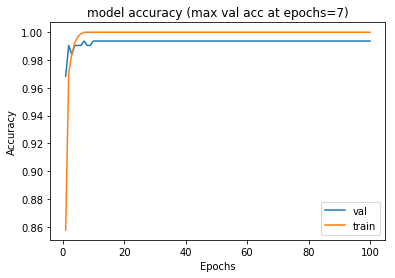

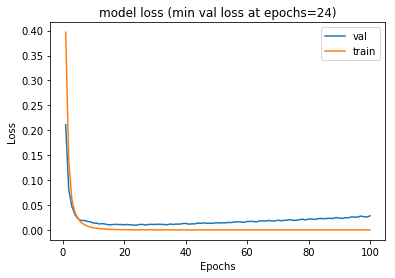

In [42]:
# print('Average validation accuracy across {0:d} folds is {1:.2f}%'.format(k,np.mean(all_scores)*100))
avg_val_acc_history = [
    np.mean([x[i] for x in all_val_acc_histories]) for i in range(num_epochs)]
avg_train_acc_history = [
    np.mean([x[i] for x in all_train_acc_histories]) for i in range(num_epochs)]
avg_val_loss_history = [
    np.mean([x[i] for x in all_val_loss_histories]) for i in range(num_epochs)]
avg_train_loss_history = [
    np.mean([x[i] for x in all_train_loss_histories]) for i in range(num_epochs)]

plt.plot(range(1, len(avg_val_acc_history) + 1), avg_val_acc_history)
plt.plot(range(1, len(avg_train_acc_history) + 1), avg_train_acc_history)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('model accuracy (max val acc at epochs={})'.format(np.argmax(avg_val_acc_history)+1))
plt.legend(['val', 'train'], loc='lower right')
plt.show()

plt.plot(range(1, len(avg_val_loss_history) + 1), avg_val_loss_history)
plt.plot(range(1, len(avg_train_loss_history) + 1), avg_train_loss_history)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('model loss (min val loss at epochs={})'.format(np.argmin(avg_val_loss_history)+1))
plt.legend(['val', 'train'], loc='upper right')
plt.show()

In [466]:
# re-run model on all of training data, stopping at epochs=16 to minimize overfitting
model = build_model()
model.fit(train_data, train_targets,
epochs=11, batch_size=16, verbose=0)
test_loss, test_acc = model.evaluate(test_data, test_targets)

print('test loss = {}'.format(test_loss))
print('test acc = {}'.format(test_acc))

80/80 [==============================] - 0s 4ms/step
test loss = 0.07432555556297302
test acc = 0.9875
